In [1]:
# import utils
from typing import Any
import torch as t
import torch.nn.functional as F
import numpy as np
import itertools
import matplotlib.pyplot as plt
import torch
%matplotlib inline
import random

In [3]:
SEEDS = [1234, 1067, 9198, 9453, 6240, 7044, 1755, 7898, 3131, 1277]

for SEED in SEEDS:
    random.seed(SEED)
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    rng = np.random.RandomState(SEED)
    torch.use_deterministic_algorithms(True)

    n = 10
    k = 5

    # Generate random parameters for the distribution: these are the initial weights
    theta = rng.randn(n)
    print(theta)

    # Create all possible_states:
    combs = list(itertools.combinations(range(n), k))
    n_states = len(combs)
    assert n_states == np.math.factorial(n)/(np.math.factorial(k)*np.math.factorial(n-k))
    
    mat_x = np.zeros((len(combs), n))
    for i in range(n_states):
        mat_x[i, combs[i]] = 1.


    # Create pytorch tensors from numpy array
    theta_t = t.from_numpy(theta).float().requires_grad_(True)
    states_t = t.from_numpy(mat_x).float()

    def tow_t(_theta):
        return states_t @ _theta

    def Z_t(_theta):
        return t.log(t.sum(t.exp(tow_t(_theta))))

    def pmf_t(_theta):
        return t.exp(tow_t(_theta) - Z_t(_theta))

    def sample_state_from_pdf(_theta):
        _pmft = pmf_t(_theta)
        indx_ch = rng.choice(list(range(n_states)), p=_pmft.detach().numpy())
        return indx_ch

    assert(t.sum(pmf_t(theta)) == 1)  # so far so good

    # Groundtruth weights
    b_t = t.abs(t.from_numpy(rng.randn(n)).float())
    print(b_t)

    sorted_bt = np.sort(b_t.detach().numpy())
    min_value_of_exp = np.sum((sorted_bt[:5])**2) + np.sum((sorted_bt[5:] - 1)**2)
    print(min_value_of_exp)
    
    # Objective function to minimize
    def objective(index):
        return t.sum((states_t[index] - b_t)**2)


    # Writing explicitly the expectation of this objective summing over
    # all possible states:
    def expectation_t(_theta):
        _pmf = pmf_t(_theta)
        _p_values = t.stack([_pmf[i] * objective(i) for i in range(n_states)])
        return t.sum(_p_values)


    # Ground truth gradient
    exact_gradient = t.autograd.grad(expectation_t(theta_t), theta_t)

    # Essentially we are now solving explicitly
    # $\min_{\theta} \mathbb{E}_{z\sim p(z, \theta)} b^\intercal z$
    # where $p(z, \theta)$ is top-k distribution.

    # With full optimization we simply write $\mathbb{E}_{z\sim p(z, \theta)} 
    # b^\intercal z= \sum_{i=1}^{N} p(z_i, \theta) b^\intercal z_i $
    # summing over all possible states, where $N=\binom{n}{k}$


    # Generic function that uses a given strategy
    # and returns the estimated gradient
    def return_grad(strategy, reinitialize=True):
        global theta_t
        if reinitialize:
            theta_t = t.from_numpy(theta).float().requires_grad_(True)

        # redefine objective with given strategy
        def objective_(_theta):
            sample = strategy(_theta)
            if len(sample.shape) == 2:
                return ((sample - b_t)**2).mean(dim=0).sum()
            else:
                return t.sum((sample - b_t)**2)

        obj = objective_(theta_t)
        obj.backward()
        return theta_t.grad

    #1. Let's try the Straight through estimator
    def ste_grad(grad_out):
        return grad_out

    def sample(_theta):
        _sampled_index = sample_state_from_pdf(_theta)
        return states_t[_sampled_index]

    def sample_many(_theta):
        _pmft = pmf_t(_theta)
        indices = torch.multinomial(_pmft, num_samples=5000, replacement=True)
        return states_t[indices]


    # define top-k sample dist with STE gradient
    class TopKTrueSamplingSTEGrad(t.autograd.Function):

        @staticmethod
        def forward(ctx, _theta):
            return sample(_theta)

        @staticmethod
        def backward(ctx, grad_outputs):
            return ste_grad(grad_outputs)

    grads = []
    for i in range(10000):
        grads += [return_grad(TopKTrueSamplingSTEGrad.apply)]
    STE = torch.stack(grads)

    # 2.  let's try I-MLE with faithful samples
    def imle_forward(ctx, _theta, _lambda):
        ctx._lambda = _lambda
        ctx._theta = _theta
        with torch.no_grad():
            ctx._fw = sample(_theta)
        return ctx._fw

    def imle_backward(ctx, grad_out):
        theta_prime = ctx._theta - ctx._lambda*grad_out #q
        sample_prime = sample(theta_prime)
        return ctx._fw - sample_prime # The gradient is the difference of sample(p) and sample(q)

    class TopKTrueSamplingIMLEGradWithImplicitQ(t.autograd.Function):

        @staticmethod
        def forward(ctx, _theta, _lambda):
            return imle_forward(ctx, _theta, _lambda)

        @staticmethod
        def backward(ctx, grad_outputs):

            grad = imle_backward(ctx, grad_outputs)
            return grad, None

    imle_ts_ap = TopKTrueSamplingIMLEGradWithImplicitQ.apply
    imle_ts_strat = lambda _th: imle_ts_ap(_th, torch.tensor(2.5))

    grads = []
    for i in range(10000):
        grads += [return_grad(imle_ts_strat)]
    ES_IMLE = torch.stack(grads)
    

    def logaddexp(x, y):
        with torch.no_grad():
            m = torch.max(x, y)
            m = m.masked_fill_(torch.isneginf(m), 0.)

        z = (x - m).exp_() + (y - m).exp_()
        mask = z == 0
        z = z.masked_fill_(mask, 1.).log_().add_(m)
        z = z.masked_fill_(mask, -float('inf'))

        return z

    def log1mexp(x):
        assert(torch.all(x >= 0))
        return torch.where(x < 0.6931471805599453094, torch.log(-torch.expm1(-x)), torch.log1p(-torch.exp(-x)))


    def prob_k(probs, k, log_space=True):
        """
        probs: a tensor of shape: (batch_size, num_vars)
        where probs[:, i] corresponds to the batch probabilities
        of Bernoulli variable Xi

        if log_space=True, we expect log_probabilities as input
        """
        batch_size = probs.size(0)
        n = probs.size(1)
        # a[:, i, j] = Pr(Sum(X1, ... , Xi) = j)
        # Note: a[:, 0, 0] corresponds to the Pr
        # that an empty sequence summing up to -1
        # which is always 0
        a = torch.zeros((batch_size, n+1, k+2), requires_grad=True)
        if log_space:
            a = torch.log(a)
        # The probability of an empty sequence
        # summing to 0 is 1
        a[:, 0, 1] = 0 if log_space else 1
        for i in range(1, n+1):

            # To get a sequence of length i with only
            # j true variables, I either take a seq.
            # with k true variables, and set variable
            # i to false, or take a sequence with k-1
            # true variables and set variable i to true
            if log_space:
                a[:, i, 1:] = logaddexp(a[:, i-1, :-1] + probs[:, i-1:i],  a[:, i-1, 1:] + log1mexp(-probs[:, i-1:i].detach()))
            else:
                a[:, i, 1:] =  a[:, i-1, :-1].clone() * probs[:, i-1:i] + a[:, i-1, 1:].clone() * (1 - probs[:, i-1:i]).detach()


        return a[:, n, k+1:k+2]

    #4.  let's try I-MLE with inexact samples and exact marginals
    _k_gamma = 5.0
    _tau_gamma = 1.0

    def sog_th1(s=10):
        return (_tau_gamma/_k_gamma)*( np.sum([rng.gamma(1.0/_k_gamma, _k_gamma/(i+1.0)) for i in range(s)] ) - np.log(s) )

    def map(_theta):
        arg_sort = t.argsort(_theta)[k:]
        _x = t.zeros(_theta.size())
        _x[arg_sort] = 1.
        return _x

    def perturb_and_map(ctx, _theta):
        if hasattr(ctx, 'eps'):
            eps = ctx.eps
        else:
            eps = t.tensor([sog_th1() for _ in range(n)])
            try: ctx.eps = eps
            except AttributeError: print('Problems with ctx')
        theta_prime = _theta + eps
        return map(theta_prime)


    def logsigmoid(x):
        return -F.softplus(-x)

    def imle_forward(ctx, _theta, _lambda):
        ctx._lambda = _lambda
        ctx._theta = _theta
        with torch.no_grad():
            ctx._fw = perturb_and_map(ctx, _theta)
        return ctx._fw

    def imle_backward(ctx, grad_out):
        with torch.enable_grad():
            theta_prime = ctx._theta - ctx._lambda*grad_out #q
            log_p = logsigmoid(ctx._theta).unsqueeze(0)
            log_q = logsigmoid(theta_prime).unsqueeze(0)
            a_p = prob_k(log_p, k)
            a_q = prob_k(log_q, k)
            mar_p = torch.autograd.grad(a_p, log_p)
            mar_q = torch.autograd.grad(a_q, log_q)
        return mar_p[0] - mar_q[0]


    class TopKTrueSamplingIMLEGradWithImplicitQ(t.autograd.Function):

        @staticmethod
        def forward(ctx, _theta, _lambda):
            return imle_forward(ctx, _theta, _lambda)

        @staticmethod
        def backward(ctx, grad_outputs):

            grad = imle_backward(ctx, grad_outputs)
            return grad, None

    imle_ts_ap = TopKTrueSamplingIMLEGradWithImplicitQ.apply
    imle_ts_strat = lambda _th: imle_ts_ap(_th, torch.tensor(2.5))

    grads = []
    for i in range(10000):
        grads += [return_grad(imle_ts_strat)]
    EM_IMLE = torch.stack(grads)

    #5.  let's try I-MLE with inexact samples and inexact marginals
    _k_gamma = 5.0
    _tau_gamma = 1.0

    def sog_th1(s=10):
        return (_tau_gamma/_k_gamma)*( np.sum([rng.gamma(1.0/_k_gamma, _k_gamma/(i+1.0)) for i in range(s)] ) - np.log(s) )

    def map(_theta):
        arg_sort = t.argsort(_theta)[k:]
        _x = t.zeros(_theta.size())
        _x[arg_sort] = 1.
        return _x

    def perturb_and_map(ctx, _theta):
        if hasattr(ctx, 'eps'):
            eps = ctx.eps
        else:
            eps = t.tensor([sog_th1() for _ in range(n)])
            try: ctx.eps = eps
            except AttributeError: print('Problems with ctx')
        theta_prime = _theta + eps
        return map(theta_prime)


    def logsigmoid(x):
        return -F.softplus(-x)

    def imle_forward(ctx, _theta, _lambda):
        ctx._lambda = _lambda
        ctx._theta = _theta
        with torch.no_grad():
            ctx._fw = perturb_and_map(ctx, _theta)
        return ctx._fw

    def imle_backward(ctx, grad_out):
        theta_prime = ctx._theta - ctx._lambda*grad_out #q
        sample_prime = perturb_and_map(ctx, theta_prime)
        return ctx._fw - sample_prime # The gradient is the difference of sample(p) and sample(q)
    

    class TopKTrueSamplingIMLEGradWithImplicitQ(t.autograd.Function):

        @staticmethod
        def forward(ctx, _theta, _lambda):
            return imle_forward(ctx, _theta, _lambda)

        @staticmethod
        def backward(ctx, grad_outputs):

            grad = imle_backward(ctx, grad_outputs)
            return grad, None

    imle_ts_ap = TopKTrueSamplingIMLEGradWithImplicitQ.apply
    imle_ts_strat = lambda _th: imle_ts_ap(_th, torch.tensor(2.5))

    grads = []
    for i in range(10000):
        grads += [return_grad(imle_ts_strat)]
    gumbel_IMLE = torch.stack(grads)

    # Softsub
    import numpy as np

    EPSILON = 1e-07

    random.seed(SEED)
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    rng = np.random.RandomState(SEED)
    torch.use_deterministic_algorithms(True)


    def gumbel_keys(w):
        uniform = torch.rand(w.shape)
        z = -torch.log(-torch.log(uniform))
        w = w + z
        return w


    def continuous_topk(w, k, t, separate=False):
        khot_list = []
        onehot_approx = torch.zeros_like(w, dtype=torch.float32)
        for i in range(k):
            khot_mask = torch.maximum(1.0 - onehot_approx, torch.full_like(onehot_approx, EPSILON))
            w += torch.log(khot_mask)
            onehot_approx = torch.nn.Softmax(dim=-1)(w/t)
            khot_list.append(onehot_approx)
        if separate:
            return khot_list
        else:
            return torch.sum(torch.stack(khot_list), dim=0)


    def sample_subset(w, k, t=2.0):
        '''
        Args:
            w (Tensor): Float Tensor of weights for each element. In gumbel mode
                these are interpreted as log probabilities
            k (int): number of elements in the subset sample
            t (float): temperature of the softmax
        '''
        w = gumbel_keys(w)
        return continuous_topk(w, k, t)

    grads = []
    for i in range(10000):
        theta_t = t.from_numpy(theta).float().requires_grad_(True)
        obj = t.sum((sample_subset(logsigmoid(theta_t), k) - b_t)**2)
        obj.backward()
        grads += [theta_t.grad]
    softsub = torch.stack(grads)

    grads = []
    for i in range(10000):
        theta_t = t.from_numpy(theta).float().requires_grad_(True)
        s = sample(theta_t)
        obj = t.sum((s - b_t)**2)
        logprob = pmf_t(theta_t)[(states_t == s).all(dim=1).nonzero().squeeze()].log()
        logprob.backward()
        grads += [theta_t.grad*obj]

    SFE = torch.stack(grads)

    #3.  let's try SIMPLE
    import functorch
    import random

    random.seed(SEED)
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    rng = np.random.RandomState(SEED)
    torch.use_deterministic_algorithms(True)

    def logsigmoid(x):
        return -F.softplus(-x)

    def imle_forward(ctx, _theta, _lambda):
        ctx._lambda = _lambda
        ctx._theta = _theta
        with torch.no_grad():
            ctx._fw = sample(_theta)
        return ctx._fw

    def log_pr_exactly_k(theta, complement_theta):
        # Note: this is written with an explicit dependence on `complement_theta = log(1 - prob)` so
        # that we can compute marginals by differentiating wrt `theta` while holding its complement fixed.
        probs = torch.exp(theta)
        complement_probs = torch.exp(complement_theta)
        a = torch.zeros([n + 1, k + 2])
        a[0, 1] = 1

        for i in range(1, n + 1):
        a [i, 1:] = a[i-1, :-1].clone() * probs[i-1] + a[i-1, 1:].clone() * complement_probs[i - 1]
        return torch.log(a[n, k + 1])

    def marginals(theta):
        log_p = torch.log(torch.sigmoid(theta))
        log_p_complement = torch.log1p(-torch.exp(log_p))
        res = functorch.grad(log_pr_exactly_k, argnums=0)(log_p, log_p_complement)
        return res

    def imle_backward(ctx, grad_out):
        return functorch.jvp(marginals, tuple([ctx._theta]), tuple([grad_out]))[1]

    class TopKTrueSamplingIMLEGradWithImplicitQ(t.autograd.Function):

        @staticmethod
        def forward(ctx, _theta, _lambda):
            return imle_forward(ctx, _theta, _lambda)

        @staticmethod
        def backward(ctx, grad_outputs):

            grad = imle_backward(ctx, grad_outputs)
            return grad, None

    imle_ts_ap = TopKTrueSamplingIMLEGradWithImplicitQ.apply
    imle_ts_strat = lambda _th: imle_ts_ap(_th, torch.tensor(0.001))

    grads = []
    for i in range(10000):
        grads += [return_grad(imle_ts_strat)]
    E_IMLE_jvp = torch.stack(grads)

    exact_gradient = exact_gradient[0].expand(10000, 10)

    gradients = {'Exact': exact_gradient, 'STE': STE, 'SoftSub':softsub,'IMLE': gumbel_IMLE, 
                 'SFE': SFE,  'SIMPLE-F': ES_IMLE, 'SIMPLE-B': EM_IMLE, 'SIMPLE': E_IMLE_jvp}

    torch.save(gradients, f'gradients_{SEED}.pt')
    
    x = ['Exact', 'SoftSub', 'IMLE', 'SFE', 'SIMPLE-F', 'SIMPLE-B', 'SIMPLE']
    x_axis = np.arange(len(x))

    # plot the bias-variance of the estimator
    y = [1.0 - F.cosine_similarity(exact_gradient.mean(axis=0), gradients[estimator].mean(axis=0), dim=0) for estimator in x]
    plt.bar(x_axis-(0.2/2), y, color='blue', width=0.2, label='Bias')

    y = []
    for estimator in x:
        mu = gradients[estimator].mean(axis=0)
        y += [F.cosine_similarity(gradients[estimator], mu).var()]
    plt.bar(x_axis+(0.2/2), y, color='red', width=0.2, label='Variance')

    plt.legend()
    ax2 = plt.twinx()
    ax2.set_ylim([0.0, 0.14])
    plt.xticks(x_axis, x)
    plt.savefig('bias_variance.png',bbox_inches='tight')
    plt.show()

    # Plot the average error of the estimators
    y = [1.0 - F.cosine_similarity(exact_gradient, gradients[estimator], dim=1).mean() for estimator in x]
    errors = [F.cosine_similarity(exact_gradient, gradients[estimator], dim=1).std() for estimator in x]
    plt.errorbar(x, y, yerr=errors, capsize=3, fmt='o', color='blue')
    plt.savefig('error.png', bbox_inches='tight')
    plt.show()

In [5]:
# 1234, 1067, 9198, 9453, 6240, 7044, 1755, 7898, 3131, 1277
gradients_0 = torch.load('gradients_1234.pt')
gradients_1 = torch.load('gradients_1067.pt')
gradients_2 = torch.load('gradients_9198.pt')
gradients_3 = torch.load('gradients_9453.pt')
gradients_4 = torch.load('gradients_6240.pt')
gradients_5 = torch.load('gradients_7044.pt')
gradients_6 = torch.load('gradients_1755.pt')
gradients_7 = torch.load('gradients_7898.pt')
gradients_8 = torch.load('gradients_3131.pt')
gradients_9 = torch.load('gradients_1277.pt')

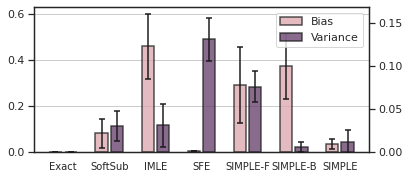

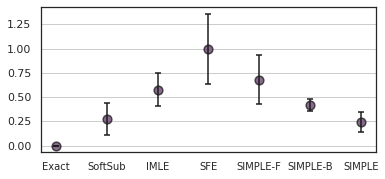

In [380]:
import math
import seaborn as sns
sns.set_theme(style="white")

sanae_colors = [sns.cubehelix_palette(as_cmap=False)[i] for i in range(6)]

x = ['Exact', 'SoftSub', 'IMLE', 'SFE', 'SIMPLE-F', 'SIMPLE-B', 'SIMPLE']

x_axis = np.arange(len(x))

# plot the bias-variance of the estimator
all_grads = [gradients_0, gradients_1, gradients_2, gradients_3, gradients_4, gradients_5, gradients_6, gradients_7, gradients_8, gradients_9]

biases = []
for gradients in all_grads:
    bias = [1.0 - F.cosine_similarity(gradients['Exact'].mean(axis=0), gradients[estimator].mean(axis=0), dim=0) for estimator in x]
    biases.append(torch.tensor(bias))
biases = torch.stack(biases)

fig, ax1 = plt.subplots(figsize=(6, 2.67));
lns1 = ax1.bar(x=[0, 3, 6, 9, 12, 15, 18], height=biases.mean(dim=0), alpha=0.75, edgecolor="k", lw=1.5, color=sanae_colors[1], label='Bias')
ax1.errorbar(x=[0, 3, 6, 9, 12, 15, 18] ,y=biases.mean(dim=0), yerr=biases.std(dim=0), fmt='none', c='k', alpha=1., zorder=3, mew=1.5, capsize=3)
ax1.grid(axis="y")
plt.xticks([0.5, 3.5, 6.5, 9.5, 12.5, 15.5, 18.5],
           x, fontsize=10)


ax2=plt.twinx()

variances = []
for gradients in all_grads:
    variance = []
    for estimator in x:
        mu = gradients[estimator].mean(axis=0)
        variance += [F.cosine_similarity(gradients[estimator], mu).var()]
    variances.append(torch.tensor(variance))
variances = torch.stack(variances)
lns3 = ax2.bar(x=[1, 4, 7, 10, 13, 16, 19], height=variances.mean(dim=0), alpha=0.75, edgecolor="k", lw=1.5, color=sanae_colors[4], label='Variance')
ax2.errorbar(x=[1, 4, 7, 10, 13, 16, 19] ,y=variances.mean(dim=0), yerr=variances.std(dim=0), fmt='none', c='k', alpha=1., zorder=3, mew=1.5, capsize=3)

ax2.set_ylim([0.0, 0.168])
plt.legend([lns1, lns3], ['Bias', 'Variance'],loc=1)

plt.savefig('bias_variance.pdf',bbox_inches='tight')
plt.show()

# Plot the average error of the estimators
errors = []
ys = []
for gradients in all_grads:
    y = [1.0 - F.cosine_similarity(gradients['Exact'], gradients[estimator], dim=1).mean() for estimator in x]
    y_ = [(1.0 - F.cosine_similarity(gradients['Exact'], gradients[estimator], dim=1)).std() for estimator in x]
    ys.append(torch.tensor(y_))
    errors.append(torch.tensor(y))
errors = torch.stack(errors)
ys = torch.stack(ys)

plt.figure(figsize=(6, 2.67))
# fig, ax1 = plt.subplots();
plt.errorbar(x=[0, 2, 4, 6, 8, 10, 12] ,y=errors.mean(dim=0), yerr=ys.mean(dim=0), fmt='none', c='k', alpha=1.,mew=1.5, capsize=3)
ax1=plt.scatter([0, 2, 4, 6, 8, 10, 12], errors.mean(dim=0), color=sanae_colors[4], alpha=0.75, edgecolor="k", lw=1.5, s=75)
# plt.xlim(-0.3, 12.3)
plt.grid(axis="y")
plt.xticks([0, 2, 4, 6, 8, 10, 12],x, fontsize=10)
plt.tick_params(axis='y', which='minor', bottom=False)
plt.savefig('errors.pdf',bbox_inches='tight')